# Co-training (For plotting only)

For visualization of co-training process, we apply PCA to feature before training. This will make co-training process clear, but the result will be not accuracy because apply PCA will loss lots of information.

1. We assume only part of label exist

2. We only select binary case (Only when one name indicate two and only two author)

3. When we apply 10 fold with co-training, each fold of first iteration will be baseline compare to co-training

In [1]:
import os
import sys
import warnings

#warnings.filterwarnings('error')
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
np.set_printoptions(precision=4, suppress=True)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import com_func

#----- threshold for selecting set of name group -----------#
threshold_select_name_group = 100
#----- threshold for selecting min sample in name group ----#
threshold_lower = 100
threshold_upper = 110

apply_threshold_to_name_group_samples = True

pp_text = ["pv_dbow"]
pp_citation = "n2v"

Dataset = "pubmed"

In [2]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt
from adjustText import adjust_text

from collections import defaultdict

# create co training classifier
class Co_training_clf(object):
    
    import copy
    
    def __init__(self, clf1, clf2=None, p=1, n=1, k=30, u = 75):
        
        self.clf1 = clf1
        # assume co_training on one classifier
        if clf2 == None:
            self.clf2 = self.copy.deepcopy(clf1)
        else:
            self.clf2 = clf2
        # take p example from most confidently positive labels to example
        self.p = p
        # take n example from most confidently negative label to example
        self.n = n
        # number of iteration
        self.k = k
        # size of pool of unlabeled samples
        self.u = u

    def init_L_U_U_prime(self, labels):
        # index of the samples that are initially labeled
        L = labels.index[labels != -1].tolist()
        # index of unlabeled samples
        U = labels.index[labels == -1].tolist()
        print("Initial L size: ", len(L))
        print("Initial U size: ", len(U))
        # random drawing sample from U
        random.shuffle(U)
        U_prime = U[-min(len(U), self.u):]
        # remove the samples in U_prime from U
        U = U[:-len(U_prime)]
        print("Initial U prime size: ", len(U_prime))
        return L, U, U_prime
    
    def check_iter_label_mapping(self, iter_clf1, iter_clf2):
        '''
        In theory, it shouldn't occur that label not mapping since it trained on same dataset but different view
        But add a check to make sure it won't occur and save the class mapping for late label unlabeled sample
        '''
        dv1_class_label = iter_clf1.classes_
        dv2_class_label = iter_clf2.classes_
        if all(dv1_class_label == dv2_class_label):
            self.class_ = dv1_class_label
        else:
            sys.exit("Two view classifier label not mapping")

    def label_p_n_samples(self, proba, rank):
        U_prime_size = len(proba)
        self_trained_labels = []
        self_trained_confident = []
        for label, conf_measure in enumerate(rank):
            # 0 positive sample
            if label==0:
                p = []
                p_confident = []
                index = 0
                while(len(p) < self.p):
                    max_conf_sample_index = conf_measure[index]
                    # ---- if positive predict proba is more than 50% ------- #
                    if (proba[max_conf_sample_index][label] > 0.5):
                        print('P: ', max_conf_sample_index, " : ", proba[max_conf_sample_index])
                        p.append(max_conf_sample_index)
                        p_confident.append(proba[max_conf_sample_index][label])
                    index +=1
                    if (index>=U_prime_size):
                        break
                self_trained_labels.append(p)
                self_trained_confident.append(p_confident)
            # 1 negative sample
            elif label == 1:
                n = []
                n_confident = []
                index = 0
                while(len(n) < self.n):
                    max_conf_sample_index = conf_measure[index]
                    # ---- if negative predict proba is more than 50% ------- #
                    if (proba[max_conf_sample_index][label] > 0.5):
                        print('N: ', max_conf_sample_index, " : ", proba[max_conf_sample_index])
                        n.append(max_conf_sample_index)
                        n_confident.append(proba[max_conf_sample_index][label])
                    index +=1
                    if (index>=U_prime_size):
                        break
                self_trained_labels.append(n)
                self_trained_confident.append(n_confident)
            else:
                print("Class label error")
        return self_trained_labels, self_trained_confident

    def get_self_labeled_sample(self):
        '''
        return:
            self-labeled new positive, self-labeled new negative (Index)
        '''
        
        return self.new_labeled_idx

    def plot_co_training_process(self, iterCount, data, iter_train_label, unlabeled_idx, h1_new = [], h2_new = [],
                                 h1_new_prob = [], h2_new_prob = [], plotSavingPath=None, name=None):
        if not os.path.exists(plotSavingPath):
            os.makedirs(plotSavingPath)
        pca_one = data.values[:,0]
        pca_two = data.values[:,1]
        # Layer 1. plot unlabel samples in u_prime
        fig, ax = plt.subplots(figsize=(9,7))
        ax.scatter(pca_one[unlabeled_idx], pca_two[unlabeled_idx], color='grey', label = "unlabeled", s = 50, alpha = 0.5)
        # Layer 2. plot the labeled samples
        for author in np.unique(iter_train_label):
            ix = iter_train_label.index[iter_train_label == author].tolist()
            # print(ix)
            ax.scatter(pca_one[ix], pca_two[ix], cmap='viridis', label = author, s = 50, alpha = 0.5)
        if iterCount != 0:
            # layer 3. mark self labeled samples
            all_h1_new = list(itertools.chain(*h1_new))
            all_h2_new = list(itertools.chain(*h2_new))
            temp_h1 = ax.scatter(pca_one[all_h1_new], pca_two[all_h1_new], edgecolor='black', linewidth='1', s=50)
            temp_h1.set_facecolor("none")
            temp_h1.set_label("h1 self-labeled")
            temp_h2 = ax.scatter(pca_one[all_h2_new], pca_two[all_h2_new], edgecolor='red', linewidth='1', s=50)
            temp_h2.set_facecolor("none")
            temp_h2.set_label("h2 self-labeled")
            # layer 4. mark new samples confidence and which view produce it
            last_iter_h1_new = h1_new[-1]
            last_iter_h2_new = h2_new[-1]
            text = []
            for i, idx in enumerate(last_iter_h1_new):
                text.append(plt.text(pca_one[idx], pca_two[idx], "{:.2f}".format(h1_new_prob[i]), color='black'))
            for i, idx in enumerate(last_iter_h2_new):
                text.append(plt.text(pca_one[idx], pca_two[idx], "{:.2f}".format(h2_new_prob[i]), color='red'))
            adjust_text(text, x=pca_one, y=pca_two, force_points=0.3, force_text=0.3, expand_points=(2, 2), 
                        expand_text=(2, 2), arrowprops=dict(arrowstyle='Simple', color='red'))
        legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3,prop={'size': 13})
        plt.title('Co-training iteration: '+ str(iterCount), fontsize=14)
        plt.xlabel("First principal component",fontsize=14)
        plt.ylabel("Second principal component",fontsize=14)
        plt.savefig((plotSavingPath+name+"_PCA_i-"+str(iterCount)+".png").encode('utf-8'), dpi=100, bbox_extra_artists=(legend,), bbox_inches='tight')
        plt.close("all")
        # plt.show()
        

    def fit(self, dataView1, dataView2, labels, dv1_test, dv2_test, label_test, plot_save_name=None, plot_save_path=None):
        # using all unlabeled sample instead of pool of unlabeled sample
        self.u = len(labels)
        # index of self labeled samples
        self.new_labeled_idx = defaultdict(list)
        self.h1_new_idx = defaultdict(list)
        self.h2_new_idx = defaultdict(list)
        
        # sync input datatype
        if not all(isinstance(i, pd.DataFrame) for i in [dataView1, dataView2, labels]):
            if not isinstance(dataView1, pd.DataFrame):
                dataView1 = pd.DataFrame(dataView1)
            if not isinstance(dataView2, pd.DataFrame):
                dataView2 = pd.DataFrame(dataView2)
            if not isinstance(labels, pd.DataFrame):
                labels = pd.DataFrame(labels, index = dataView1.index.values)
        labels = pd.Series(labels[0].values, index=dataView1.index.values) 
        # when fit co-train, we collect f1 on test samples wrt each iteration
        self.f1_on_test_dv1 = []
        self.f1_on_test_dv2 = []
        
        print("P value: ", self.p, " N value: ", self.n)
        print(dataView1.index.values)
        
        L, U, U_prime = self.init_L_U_U_prime(labels)
        print("L: ", L)
        print("U: ", U)
        print("U_prime: ", U_prime)
        
        iterCount = 0
        # --------- plot initial stage -------------- #
        init_train_label = labels[L]
        plot_save_dv1_name = plot_save_name+"_dv1"
        if plot_save_name != None:
            # ----- save pca reduced plot for dv1 ------ #
            self.plot_co_training_process(iterCount, dataView1, init_train_label, U_prime,
                                          plotSavingPath = plot_save_path, name = plot_save_dv1_name)
            # ----- dv2 -------- #
            plot_save_dv2_name = plot_save_name+"_dv2"
            self.plot_co_training_process(iterCount, dataView2, init_train_label, U_prime,
                                          plotSavingPath = plot_save_path, name = plot_save_dv2_name)
        
        #loop until we have assigned labels to every sample in U and U_prime or we hit our iteration break condition
        while iterCount < self.k and U_prime:
            # print("step",iterCount, " L: ",L)
            # print("step",iterCount, " U_prime: ",U_prime)
            # ------------- get labeled samples for train ----------- # 
            iter_train_d1 = dataView1.iloc[L]
            iter_train_d2 = dataView2.iloc[L]
            iter_train_label = labels[L]
            # print(iter_train_label)
            # ----------- get U_prime unlabeled samples  ------------ #
            iter_unlabeled_d1 = dataView1.iloc[U_prime]
            iter_unlabeled_d2 = dataView2.iloc[U_prime]
            # ------------ train different view classifier ----------- #
            iter_clf1 = self.copy.deepcopy(self.clf1) 
            iter_clf2 = self.copy.deepcopy(self.clf2)
            iter_clf1.fit(iter_train_d1, iter_train_label.ravel())
            iter_clf2.fit(iter_train_d2, iter_train_label.ravel())
            self.check_iter_label_mapping(iter_clf1, iter_clf2)
            # --------- test error on test data --------------------- #
            # make prediction on test data
            y1 = iter_clf1.predict(dv1_test)
            y2 = iter_clf2.predict(dv2_test)
            # f1 score on each iteration
            f1_dv1 = f1_score(label_test, y1, average='macro')
            f1_dv2 = f1_score(label_test, y2, average='macro')
            # collect f1 for current iteration
            self.f1_on_test_dv1.append(f1_dv1)
            self.f1_on_test_dv2.append(f1_dv2)
            ''' 
            Notice here dv1_proba and dv2_proba's index is index for u' (Unlabeled data only)
            We use index of u' to find index (position) of data in U where U and L is all data index
            '''
            # rank class probabilities for unlabeled sample for it's confidence measure
            dv1_proba = iter_clf1.predict_proba(iter_unlabeled_d1)
            dv2_proba = iter_clf2.predict_proba(iter_unlabeled_d2)
            dv1_proba_rank = []
            dv2_proba_rank = []
            # proba1_rank[i] is label i's confidence measure
            for class_proba in dv1_proba.T:
                dv1_proba_rank.append((-class_proba).argsort())
            for class_proba in dv2_proba.T:
                dv2_proba_rank.append((-class_proba).argsort())
            # print(dv1_proba)
            # print(dv1_proba_rank)
            # print(dv2_proba)
            # print(dv2_proba_rank)
            # h1 classifier
            h1_new_sample, h1_new_sample_probs = self.label_p_n_samples(dv1_proba, dv1_proba_rank)
            # h2 classifier
            h2_new_sample, h2_new_sample_probs = self.label_p_n_samples(dv2_proba, dv2_proba_rank)
            # collect statistic for plot only
            h1_new_flatten = list(itertools.chain(*h1_new_sample))
            h2_new_flatten = list(itertools.chain(*h2_new_sample))
            iter_h1_prob = list(itertools.chain(*h1_new_sample_probs))
            iter_h2_prob = list(itertools.chain(*h2_new_sample_probs))
            iter_h1_for_plot = [U_prime[x] for x in h1_new_flatten]
            iter_h2_for_plot = [U_prime[x] for x in h2_new_flatten]
            self.h1_new_idx["index"].append(iter_h1_for_plot)
            self.h1_new_idx["confident"].append(iter_h1_prob)
            self.h2_new_idx["index"].append(iter_h2_for_plot)
            self.h2_new_idx["confident"].append(iter_h2_prob)
            # add most confidence samples as new training samples
            roundNew = list(zip(h1_new_sample, h2_new_sample))
            print(roundNew)
            # auto label the samples and remove it from U_prime
            round_auto_labeled = []
            for label, round_new in enumerate(roundNew):
                round_new = set([item for sublist in round_new for item in sublist])
                auto_labeled = [U_prime[x] for x in round_new]
                round_auto_labeled.extend(auto_labeled)
                self.new_labeled_idx[self.class_[label]].append(auto_labeled)
                # add label to those new samples
                labels[auto_labeled] = self.class_[label]
                print(self.class_[label]," (u' idx): ",round_new)
                print(self.class_[label]," (U idx): ",auto_labeled)
            print(roundNew)
            print(round_auto_labeled)
            # extend the labeled sample
            L.extend(round_auto_labeled)
            # remove the labeled sample from U_prime
            U_prime = [x for x in U_prime if x not in round_auto_labeled]
            #print(U_prime)
            # randomly choice 2p+2n examples from u to replenish u_prime
            replenishItem = U[-(2*self.p+2*self.n):]
            U_prime.extend(replenishItem)
            U = U[:-len(replenishItem)]
            iterCount +=1
            # ----------- plot the co-training process -------------- #
#             if plot_save_name != None:
#                 new_train_label = labels[L]
#                 h1_new = self.h1_new_idx["index"]
#                 h2_new = self.h2_new_idx["index"]
#                 # self_labeled_idx = [val for sublist in self_labeled_idx_temp for subsublist in sublist for val in subsublist]
#                 print("Current iter h1 new: ", iter_h1_for_plot, " probs: ", iter_h1_prob)
#                 print("Current iter h2 new: ", iter_h2_for_plot, " probs: ", iter_h2_prob)
#                 # ----- save pca reduced plot for dv1 ------ #
#                 plot_save_dv1_name = plot_save_name+"_dv1"
#                 self.plot_co_training_process(iterCount, dataView1, new_train_label, U_prime,
#                                               h1_new, h2_new, iter_h1_prob, iter_h2_prob,
#                                               plot_save_path, plot_save_dv1_name)
#                 # ----- dv2 -------- #
#                 plot_save_dv2_name = plot_save_name+"_dv2"
#                 self.plot_co_training_process(iterCount, dataView2, new_train_label, U_prime,
#                                               h1_new, h2_new, iter_h1_prob, iter_h2_prob,
#                                               plot_save_path, plot_save_dv2_name)
        print("Total Labeled number: ", len(L), " Still unlabeled number: ", len(U_prime))
        print(self.f1_on_test_dv1)
        print(self.f1_on_test_dv2)
        # final train
        newtrain_d1 = dataView1.iloc[L]
        newtrain_d2 = dataView2.iloc[L]
        self.clf1.fit(newtrain_d1, labels.iloc[L])
        self.clf2.fit(newtrain_d2, labels.iloc[L])
        # ------ save f1 vs number of iteration plot ------- #
        if plot_save_name != None:
            default_text_based = [self.f1_on_test_dv1[0]] * iterCount
            default_citation_based = [self.f1_on_test_dv2[0]] * iterCount
            default_step = np.arange(0,iterCount)
            co_train_text_based = self.f1_on_test_dv1[1:]
            co_train_citation_based = self.f1_on_test_dv2[1:]
            co_training_step = np.arange(1,iterCount)

            fig = plt.figure()
            ax = plt.axes()
            plt.plot(default_step, default_text_based, linestyle='dashed', label="Text based default")
            plt.plot(default_step, default_citation_based, linestyle='dashdot', label="Citation based default")
            plt.plot(co_training_step, co_train_text_based, linestyle='solid', marker = "*", label="Text based")
            plt.plot(co_training_step, co_train_citation_based, linestyle='dotted', marker = "+", label="Citation based")
            ax.autoscale_view()
            legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
            plt.xlabel('Co-Training Iterations')
            plt.ylabel('F1 score')
            plt.savefig((plot_save_path+plot_save_name+"_diff_iter_f1.png"), dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
            # plt.show()
            plt.close("all")
            
    def co_train_process_f1(self):
        return self.f1_on_test_dv1, self.f1_on_test_dv2

    def get_iter_count(self):
        return self.k

    def supports_proba(self, clf, x):
        try:
            clf.predict_proba([x])
            return True
        except:
            return False

    def predict(self, dataView1, dataView2):
        y1 = self.clf1.predict(dataView1)
        y2 = self.clf2.predict(dataView2)
        proba_supported = self.supports_proba(self.clf1, dataView1.iloc[0]) and self.supports_proba(self.clf2, dataView2.iloc[0])
        #fill pred with -1 so we can identify the samples in which sample classifiers failed to agree
        y_pred = ["-1"] * dataView1.shape[0]
        for i, (y1_i, y2_i) in enumerate(zip(y1, y2)):
            # if both agree on label
            if y1_i == y2_i:
                y_pred[i] = y1_i
            # if disagree on label, times probability together, choice the class have higher probabilities
            elif proba_supported:
                y1_probas = self.clf1.predict_proba([dataView1.iloc[i]])[0]
                y2_probas = self.clf2.predict_proba([dataView2.iloc[i]])[0]
                print("y1 disagree on",i, " Proba: ",y1_probas)
                print("y2 not aggreed on ",i, "Proba: ", y2_probas)
                prod_y_probas = [proba_y1 * proba_y2 for (proba_y1, proba_y2) in zip(y1_probas, y2_probas)]
                print("product probas:",prod_y_probas)
                max_prob_idx = prod_y_probas.index(max(prod_y_probas))
                y_pred[i] = self.class_[max_prob_idx]
                print("result idx: ", max_prob_idx, " result: ",y_pred[i])
            else:
                #the classifiers disagree and don't support probability, exit
                sys.exit("classifiers disagree with label, result may not accurate")
        # convert final result to np array
        y_pred_np_array = np.asarray(y_pred)
        return y_pred_np_array

    def predict_proba(self, dataView1, dataView2):
        # the predicted probabilities is simply a product (*) of probabilities given from each classifier trained
        y1_probas = self.clf1.predict_proba(dataView1)
        y2_probas = self.clf2.predict_proba(dataView2)
        
        proba = (y1_probas*y2_probas)
        return proba


In [3]:
import copy
import random

import seaborn as sns

from collections import Counter
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

# cross validation
def k_fold_cv_co_train_binary(dataview1, dataview2, label, init_labeled_size, clf, k=10, plot_save_name=None, plot_save_path=None):
    kf = StratifiedKFold(n_splits=k)
    allTrueLabel = []
    allPredLabel_co_train = []
    all_fold_coTrain_diff_iter_on_test_dv1 = []
    all_fold_coTrain_diff_iter_on_test_dv2 = []
    
    all_fold_statistic = []
    fold = 0
    co_train_iteration = 0
    # convert different input type to dataframe for consistency
    dataview1 = pd.DataFrame(dataview1)
    dataview2 = pd.DataFrame(dataview2)
    
    for train_index, test_index in kf.split(dataview1, label):
        detailed_plot_path = plot_save_path+plot_save_name+"/fold"+str(fold)+"/"
        fold +=1
        # print("TRAIN:", train_index, " \n TEST:", test_index)
        # ---------------split train and test -------------------- #
        dv1_train, dv1_test = dataview1.iloc[train_index], dataview1.iloc[test_index]
        dv2_train, dv2_test = dataview2.iloc[train_index], dataview2.iloc[test_index]
        all_label_train, label_test = label.iloc[train_index], label.iloc[test_index]
        
        # plot true labeled result for different view
        if not os.path.exists(detailed_plot_path):
            os.makedirs(detailed_plot_path)
        # view one
        dv1_pca_one = dv1_train.iloc[:,0]
        dv1_pca_two = dv1_train.iloc[:,1]
        fig, ax = plt.subplots(figsize=(9,7))
        for author in np.unique(all_label_train):
            ix = all_label_train.index[all_label_train == author].tolist()
            ax.scatter(dv1_pca_one[ix], dv1_pca_two[ix], cmap='viridis', label = author, s = 50, alpha = 0.5)
        legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2,prop={'size': 13})
        plt.title('True label', fontsize=14)
        plt.xlabel("First principal component",fontsize=14)
        plt.ylabel("Second principal component",fontsize=14)
        plt.savefig((detailed_plot_path+name+"_PCA_true_label_dv1.png").encode('utf-8'), dpi=100, bbox_extra_artists=(legend,), bbox_inches='tight')
        # view two
        dv2_pca_one = dv2_train.iloc[:,0]
        dv2_pca_two = dv2_train.iloc[:,1]
        fig, ax = plt.subplots(figsize=(9,7))
        for author in np.unique(all_label_train):
            ix = all_label_train.index[all_label_train == author].tolist()
            ax.scatter(dv2_pca_one[ix], dv2_pca_two[ix], cmap='viridis', label = author, s = 50, alpha = 0.5)
        legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2,prop={'size': 13})
        plt.title('True label', fontsize=14)
        plt.xlabel("First principal component",fontsize=14)
        plt.ylabel("Second principal component",fontsize=14)
        plt.savefig((detailed_plot_path+name+"_PCA_true_label_dv2.png").encode('utf-8'), dpi=100, bbox_extra_artists=(legend,), bbox_inches='tight')
        
        print(dv1_train.head())
        print(all_label_train.head())
        # ----------- set some labeled data as unlabeled ------------ #
        # 1. obtain data ratio
        c = Counter(all_label_train)
        data_ratio = [(i, c[i] / len(all_label_train)) for i in c]
        print(data_ratio)
        # 2. use co_train_per_class_size to draw "init_labeled_size" of samples as labeled, other as unlabeled
        co_train_per_class_size = [(label, round(ratio*init_labeled_size)) for label, ratio in data_ratio]
        final_train_label = all_label_train.tolist()
        train_sample_idx = []
        # 3. mark other as unlabeled
        for unique_label, training_size in co_train_per_class_size:
            curr_label_idx = [i for i, x in enumerate(final_train_label) if x == unique_label]
            curr_label_size = len(curr_label_idx)
            unlabeled_size = curr_label_size - training_size
            unlabel_item_idx = random.sample(curr_label_idx, unlabeled_size)
            train_sample_idx += [x for x in curr_label_idx if x not in unlabel_item_idx]
            for unlabel_idx in unlabel_item_idx:
                final_train_label[unlabel_idx]=-1
        print(final_train_label)
        unlabeled_sample_size = len(final_train_label)-len(train_sample_idx)
        final_dv1_train = dv1_train.reset_index(drop=True)
        final_dv2_train = dv2_train.reset_index(drop=True)
        ''' -------------- train binary co-training ------------------- '''
        per_fold_clf = copy.deepcopy(clf)
        per_fold_clf.fit(final_dv1_train, final_dv2_train, final_train_label, dv1_test, dv2_test, label_test,
                         plot_save_name, detailed_plot_path)
        # get self-labeled sample index #
        self_labeled_index = per_fold_clf.get_self_labeled_sample()
        print("Self labeled sample index: ", self_labeled_index)
        self_labeled_idx_temp = [idx for idx in self_labeled_index.values()]
        all_self_labeled_index = [val for sublist in self_labeled_idx_temp for subsublist in sublist for val in subsublist]
        # ------------- get predicted label for test set ------------- #
        co_lr_label_predict = per_fold_clf.predict(dv1_test, dv2_test)
        # ------------- get co-training iterations f1 score ---------- #
        co_train_iteration = per_fold_clf.get_iter_count()
        coTrain_diff_iter_on_test_dv1, coTrain_diff_iter_on_test_dv2 = per_fold_clf.co_train_process_f1()
        all_fold_coTrain_diff_iter_on_test_dv1.append(coTrain_diff_iter_on_test_dv1)
        all_fold_coTrain_diff_iter_on_test_dv2.append(coTrain_diff_iter_on_test_dv2)
        print("co-train f1: ", metrics.classification_report(label_test, co_lr_label_predict))
        
        allTrueLabel.extend(label_test.values.tolist())
        allPredLabel_co_train.extend(co_lr_label_predict)
        # collect per fold statistic
        curr_fold_statistic = {'author': plot_save_name, 'fold':fold, 'train_size': co_train_per_class_size, 'test_size': dv1_test.shape[0],
                               'total_self_labeled_train': len(all_self_labeled_index), "unlabeled size": unlabeled_sample_size,
                               'co-train f1': f1_score(label_test.values.tolist(), co_lr_label_predict,average='macro')}
        all_fold_statistic.append(curr_fold_statistic)
    
    # plot averaged f1 score on co-training in different iterations
    averaged_coTrain_diff_iter_on_test_dv1 = np.mean(all_fold_coTrain_diff_iter_on_test_dv1, axis=0)
    averaged_coTrain_diff_iter_on_test_dv2 = np.mean(all_fold_coTrain_diff_iter_on_test_dv2, axis=0)
    
    default_text_based = [averaged_coTrain_diff_iter_on_test_dv1[0]] * co_train_iteration
    default_citation_based = [averaged_coTrain_diff_iter_on_test_dv2[0]] * co_train_iteration
    default_step = np.arange(0, co_train_iteration)
    co_train_text_based = averaged_coTrain_diff_iter_on_test_dv1[1:]
    co_train_citation_based = averaged_coTrain_diff_iter_on_test_dv2[1:]
    co_training_step = np.arange(1, co_train_iteration)

    fig = plt.figure()
    ax = plt.axes()
    plt.plot(default_step, default_text_based, linestyle='dashed', label="Text based default")
    plt.plot(default_step, default_citation_based, linestyle='dashdot', label="Citation based default")
    plt.plot(co_training_step, co_train_text_based, linestyle='solid', marker = "*", label="Text based")
    plt.plot(co_training_step, co_train_citation_based, linestyle='dotted', marker = "+", label="Citation based")
    ax.autoscale_view()
    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
    plt.xlabel('Co-Training Iterations')
    plt.ylabel('F1 score')
    plt.savefig((plot_save_path+plot_save_name+"_diff_iter_f1_avg.png"), dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()
    plt.close("all")
    
    co_train_accuracy = accuracy_score(allTrueLabel, allPredLabel_co_train)
    co_train_f1 = f1_score(allTrueLabel, allPredLabel_co_train,average='macro')
    print(metrics.classification_report(allTrueLabel, allPredLabel_co_train))
    print(metrics.confusion_matrix(allTrueLabel, allPredLabel_co_train).ravel())

    
    return co_train_f1, all_fold_statistic

Load text embedding:  pv_dbow
Total text vector records: 135796
Vector dimension:  100
Load citation embedding:  n2v
Total citation vector records: 124922
Vector dimension:  101
For name:  j_read
(136, 2)
j_read  pass
For name:  f_esteves
(34, 2)
f_esteves  pass
For name:  c_miller
(252, 2)
c_miller  pass
For name:  r_jha
(11, 2)
r_jha  pass
For name:  a_lowe
(102, 2)
a_lowe  pass
For name:  a_vega
(20, 2)
a_vega  pass
For name:  k_smith
(338, 2)
k_smith  pass
For name:  j_gordon
(19, 2)
j_gordon  pass
For name:  s_liao
(104, 2)
s_liao  pass
For name:  j_qian
(17, 2)
j_qian  pass
For name:  s_bernardi
(91, 2)
s_bernardi  pass
For name:  t_hill
(15, 2)
t_hill  pass
For name:  s_schindler
(51, 2)
s_schindler  pass
For name:  j_williams
(625, 2)
j_williams  pass
For name:  s_jacobson
(28, 2)
s_jacobson  pass
For name:  e_andrade
(17, 2)
e_andrade  pass
For name:  t_santos
(45, 2)
t_santos  pass
For name:  k_kim
(1111, 2)
Total sample size before apply threshold:  1111
Counter({'0000-0002-

Total missing sample:  0
(252, 101)
Total missing sample:  6
(252, 101)
Labeled:  252  :  252
(252, 103)
(252, 103)
p_robinson is binary case
           0         1
19  1.348390  1.122011
24  1.741000 -1.104413
25  1.041637 -1.788082
27  1.227194 -0.089107
28  0.342072  0.527845
19    p_robinson_0
24    p_robinson_0
25    p_robinson_0
27    p_robinson_0
28    p_robinson_0
Name: authorID, dtype: object
[('p_robinson_0', 0.47345132743362833), ('p_robinson_1', 0.5265486725663717)]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 'p_robinson_1', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 'p_robinson_1', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 'p_robinson_0', -1, -1, -1, -1, -1, -1, -1, -1, 

N:  143  :  [0.0144 0.9856]
[([72], [47]), ([105], [143])]
p_robinson_0  (u' idx):  {72, 47}
p_robinson_0  (U idx):  [158, 46]
p_robinson_1  (u' idx):  {105, 143}
p_robinson_1  (U idx):  [204, 14]
[([72], [47]), ([105], [143])]
[158, 46, 204, 14]
P:  111  :  [0.9631 0.0369]
N:  79  :  [0.027 0.973]
P:  140  :  [0.9773 0.0227]
N:  11  :  [0.0123 0.9877]
[([111], [140]), ([79], [11])]
p_robinson_0  (u' idx):  {140, 111}
p_robinson_0  (U idx):  [17, 41]
p_robinson_1  (u' idx):  {11, 79}
p_robinson_1  (U idx):  [109, 59]
[([111], [140]), ([79], [11])]
[17, 41, 109, 59]
P:  149  :  [0.9667 0.0333]
N:  34  :  [0.0254 0.9746]
P:  83  :  [0.9741 0.0259]
N:  14  :  [0.0113 0.9887]
[([149], [83]), ([34], [14])]
p_robinson_0  (u' idx):  {83, 149}
p_robinson_0  (U idx):  [118, 165]
p_robinson_1  (u' idx):  {34, 14}
p_robinson_1  (U idx):  [24, 43]
[([149], [83]), ([34], [14])]
[118, 165, 24, 43]
P:  114  :  [0.9684 0.0316]
N:  13  :  [0.0231 0.9769]
P:  129  :  [0.9752 0.0248]
N:  122  :  [0.011 0

Self labeled sample index:  defaultdict(<class 'list'>, {'p_robinson_0': [[68, 85], [55, 137], [87, 131], [99, 105], [158, 46], [17, 41], [118, 165], [129, 53], [210, 48], [186], [124, 10], [50], [8, 147], [217, 157], [202, 214], [90, 52], [96, 130], [168], [112, 205], [1, 209], [27, 212], [65, 73], [111, 13], [56, 155], [206, 133], [183, 45], [4, 119], [32, 75], [198, 58], [3]], 'p_robinson_1': [[89, 94], [170, 122], [6, 5], [49, 103], [204, 14], [109, 59], [24, 43], [163, 176], [135, 38], [150, 82], [181, 88], [175, 93], [126, 166], [108, 20], [185, 159], [23, 25], [167, 77], [116, 154], [218, 144], [190], [169, 42], [110, 219], [207, 203], [80, 134], [125, 11], [193, 173], [224, 31], [91, 162], [33, 84], [98, 191]]})
y1 disagree on 19  Proba:  [0.0366 0.9634]
y2 not aggreed on  19 Proba:  [0.6474 0.3526]
product probas: [0.02367904925885837, 0.33972366649450086]
result idx:  1  result:  p_robinson_1
y1 disagree on 23  Proba:  [0.1565 0.8435]
y2 not aggreed on  23 Proba:  [0.6725 0.3

p_robinson_0  (U idx):  [112, 53]
p_robinson_1  (u' idx):  {137, 14}
p_robinson_1  (U idx):  [144, 218]
[([122], [104]), ([137], [14])]
[112, 53, 144, 218]
P:  51  :  [0.9872 0.0128]
N:  0  :  [0.0285 0.9715]
P:  83  :  [0.9857 0.0143]
N:  49  :  [0.0132 0.9868]
[([51], [83]), ([0], [49])]
p_robinson_0  (u' idx):  {83, 51}
p_robinson_0  (U idx):  [96, 209]
p_robinson_1  (u' idx):  {0, 49}
p_robinson_1  (U idx):  [219, 110]
[([51], [83]), ([0], [49])]
[96, 209, 219, 110]
P:  137  :  [0.9876 0.0124]
N:  106  :  [0.0285 0.9715]
P:  138  :  [0.984 0.016]
N:  97  :  [0.0127 0.9873]
[([137], [138]), ([106], [97])]
p_robinson_0  (u' idx):  {137, 138}
p_robinson_0  (U idx):  [205, 1]
p_robinson_1  (u' idx):  {97, 106}
p_robinson_1  (U idx):  [167, 134]
[([137], [138]), ([106], [97])]
[205, 1, 167, 134]
P:  91  :  [0.9892 0.0108]
N:  64  :  [0.0264 0.9736]
P:  113  :  [0.983 0.017]
N:  124  :  [0.0124 0.9876]
[([91], [113]), ([64], [124])]
p_robinson_0  (u' idx):  {113, 91}
p_robinson_0  (U idx

P:  88  :  [0.9526 0.0474]
N:  211  :  [0.0573 0.9427]
P:  76  :  [0.9463 0.0537]
N:  84  :  [0.0295 0.9705]
[([88], [76]), ([211], [84])]
p_robinson_0  (u' idx):  {88, 76}
p_robinson_0  (U idx):  [35, 138]
p_robinson_1  (u' idx):  {211, 84}
p_robinson_1  (U idx):  [90, 95]
[([88], [76]), ([211], [84])]
[35, 138, 90, 95]
P:  49  :  [0.9636 0.0364]
N:  116  :  [0.0414 0.9586]
P:  72  :  [0.9612 0.0388]
N:  105  :  [0.0244 0.9756]
[([49], [72]), ([116], [105])]
p_robinson_0  (u' idx):  {72, 49}
p_robinson_0  (U idx):  [132, 86]
p_robinson_1  (u' idx):  {105, 116}
p_robinson_1  (U idx):  [171, 102]
[([49], [72]), ([116], [105])]
[132, 86, 171, 102]
P:  204  :  [0.9709 0.0291]
N:  95  :  [0.0361 0.9639]
P:  205  :  [0.9717 0.0283]
N:  181  :  [0.0149 0.9851]
[([204], [205]), ([95], [181])]
p_robinson_0  (u' idx):  {204, 205}
p_robinson_0  (U idx):  [106, 19]
p_robinson_1  (u' idx):  {181, 95}
p_robinson_1  (U idx):  [54, 123]
[([204], [205]), ([95], [181])]
[106, 19, 54, 123]
P:  197  :  [

Self labeled sample index:  defaultdict(<class 'list'>, {'p_robinson_0': [[35, 138], [132, 86], [106, 19], [88, 100], [159, 72], [41, 67], [17, 166], [37, 211], [63, 74], [130, 187], [119], [125, 148], [8, 158], [91, 203], [215, 112], [97, 80], [169, 218], [113, 131], [56, 206], [18, 1], [24, 105], [48, 210], [13, 213], [71, 156], [134, 207], [83, 184], [4, 120], [3, 199], [58, 108], [52]], 'p_robinson_1': [[90, 95], [171, 102], [54, 123], [6, 5], [104, 205], [177, 14], [64, 110], [30, 69], [164, 151], [136, 182], [176, 94], [160, 89], [127, 167], [21, 109], [186, 26], [31, 168], [155, 117], [219, 145], [204, 191], [170, 68], [135, 111], [174, 208], [49, 126], [220, 194], [11, 225], [57, 33], [92, 50], [32, 163], [85, 59], [99, 192]]})
y1 disagree on 5  Proba:  [0.0274 0.9726]
y2 not aggreed on  5 Proba:  [0.5331 0.4669]
product probas: [0.014594648756585721, 0.4541034043921075]
result idx:  1  result:  p_robinson_1
y1 disagree on 9  Proba:  [0.2149 0.7851]
y2 not aggreed on  9 Proba: 

N:  82  :  [0.0132 0.9868]
[([4], [38]), ([61], [82])]
p_robinson_0  (u' idx):  {4, 38}
p_robinson_0  (U idx):  [112, 131]
p_robinson_1  (u' idx):  {82, 61}
p_robinson_1  (U idx):  [168, 117]
[([4], [38]), ([61], [82])]
[112, 131, 168, 117]
P:  124  :  [0.9792 0.0208]
N:  108  :  [0.0199 0.9801]
P:  91  :  [0.9668 0.0332]
N:  139  :  [0.0131 0.9869]
[([124], [91]), ([108], [139])]
p_robinson_0  (u' idx):  {91, 124}
p_robinson_0  (U idx):  [1, 203]
p_robinson_1  (u' idx):  {139, 108}
p_robinson_1  (U idx):  [191, 145]
[([124], [91]), ([108], [139])]
[1, 203, 191, 145]
P:  76  :  [0.9769 0.0231]
N:  88  :  [0.0233 0.9767]
P:  53  :  [0.9638 0.0362]
N:  125  :  [0.0114 0.9886]
[([76], [53]), ([88], [125])]
p_robinson_0  (u' idx):  {76, 53}
p_robinson_0  (U idx):  [206, 24]
p_robinson_1  (u' idx):  {88, 125}
p_robinson_1  (U idx):  [68, 170]
[([76], [53]), ([88], [125])]
[206, 24, 68, 170]
P:  141  :  [0.9786 0.0214]
N:  77  :  [0.0223 0.9777]
P:  44  :  [0.9636 0.0364]
N:  79  :  [0.0106 

Initial U prime size:  217
L:  [28, 86, 119, 129, 130, 133, 179, 207, 219, 221]
U:  []
U_prime:  [136, 102, 48, 186, 78, 8, 152, 224, 209, 52, 47, 45, 76, 191, 59, 88, 94, 29, 103, 132, 3, 197, 218, 1, 35, 61, 54, 217, 18, 164, 51, 79, 121, 194, 41, 157, 89, 72, 226, 177, 77, 116, 124, 9, 15, 74, 212, 205, 181, 137, 67, 208, 20, 120, 16, 71, 12, 113, 214, 189, 109, 96, 155, 225, 4, 110, 87, 39, 175, 140, 33, 93, 65, 216, 222, 58, 131, 14, 108, 172, 200, 206, 166, 105, 174, 203, 123, 21, 192, 178, 70, 165, 7, 17, 6, 142, 85, 122, 195, 139, 69, 30, 154, 53, 153, 176, 215, 211, 138, 19, 150, 117, 24, 73, 56, 83, 196, 75, 146, 127, 42, 128, 148, 23, 199, 82, 111, 100, 107, 184, 97, 193, 64, 182, 104, 99, 95, 31, 159, 173, 46, 11, 118, 171, 141, 13, 26, 34, 22, 101, 55, 158, 162, 91, 144, 188, 161, 114, 112, 40, 180, 49, 25, 0, 44, 38, 32, 50, 167, 36, 90, 37, 81, 92, 213, 98, 156, 147, 106, 84, 145, 151, 63, 135, 27, 149, 187, 190, 223, 163, 126, 170, 198, 5, 134, 62, 115, 204, 169, 201, 4

P:  89  :  [0.9823 0.0177]
N:  63  :  [0.0217 0.9783]
P:  75  :  [0.98 0.02]
N:  17  :  [0.0184 0.9816]
[([89], [75]), ([63], [17])]
p_robinson_0  (u' idx):  {89, 75}
p_robinson_0  (U idx):  [158, 184]
p_robinson_1  (u' idx):  {17, 63}
p_robinson_1  (U idx):  [121, 117]
[([89], [75]), ([63], [17])]
[158, 184, 121, 117]
P:  104  :  [0.985 0.015]
N:  48  :  [0.022 0.978]
P:  103  :  [0.9799 0.0201]
N:  17  :  [0.0179 0.9821]
[([104], [103]), ([48], [17])]
p_robinson_0  (u' idx):  {104, 103}
p_robinson_0  (U idx):  [147, 156]
p_robinson_1  (u' idx):  {48, 17}
p_robinson_1  (U idx):  [174, 194]
[([104], [103]), ([48], [17])]
[147, 156, 174, 194]
P:  11  :  [0.9847 0.0153]
N:  101  :  [0.0218 0.9782]
P:  74  :  [0.981 0.019]
N:  110  :  [0.0212 0.9788]
[([11], [74]), ([101], [110])]
p_robinson_0  (u' idx):  {74, 11}
p_robinson_0  (U idx):  [99, 3]
p_robinson_1  (u' idx):  {101, 110}
p_robinson_1  (U idx):  [145, 204]
[([11], [74]), ([101], [110])]
[99, 3, 145, 204]
P:  5  :  [0.9849 0.0151]

P:  211  :  [0.9585 0.0415]
N:  135  :  [0.0885 0.9115]
P:  191  :  [0.9676 0.0324]
N:  193  :  [0.0317 0.9683]
[([211], [191]), ([135], [193])]
p_robinson_0  (u' idx):  {211, 191}
p_robinson_0  (U idx):  [35, 94]
p_robinson_1  (u' idx):  {193, 135}
p_robinson_1  (U idx):  [54, 75]
[([211], [191]), ([135], [193])]
[35, 94, 54, 75]
P:  208  :  [0.9671 0.0329]
N:  63  :  [0.0631 0.9369]
P:  212  :  [0.9731 0.0269]
N:  150  :  [0.0242 0.9758]
[([208], [212]), ([63], [150])]
p_robinson_0  (u' idx):  {208, 212}
p_robinson_0  (U idx):  [111, 125]
p_robinson_1  (u' idx):  {150, 63}
p_robinson_1  (U idx):  [5, 115]
[([208], [212]), ([63], [150])]
[111, 125, 5, 115]
P:  142  :  [0.9756 0.0244]
N:  107  :  [0.0542 0.9458]
P:  127  :  [0.9776 0.0224]
N:  138  :  [0.0222 0.9778]
[([142], [127]), ([107], [138])]
p_robinson_0  (u' idx):  {142, 127}
p_robinson_0  (U idx):  [131, 19]
p_robinson_1  (u' idx):  {138, 107}
p_robinson_1  (U idx):  [129, 127]
[([142], [127]), ([107], [138])]
[131, 19, 129, 

Self labeled sample index:  defaultdict(<class 'list'>, {'p_robinson_0': [[35, 94], [111, 125], [131, 19], [72, 81], [113, 41], [17, 10], [37, 67], [63, 159], [203, 187], [79, 74], [166, 8], [211, 116], [144], [76, 122], [154, 138], [158, 169], [48, 78], [56, 206], [137, 91], [1, 210], [24, 213], [82, 13], [71, 207], [157, 99], [4, 184], [58, 145], [101, 84], [3, 199], [52, 133], [183, 153]], 'p_robinson_1': [[54, 75], [5, 115], [129, 127], [148, 14], [135, 205], [69, 6], [164, 85], [119, 177], [114, 64], [160, 108], [167, 182], [168, 30], [186, 176], [103, 21], [31, 26], [151, 219], [191, 134], [170, 142], [68, 106], [136, 49], [220, 225], [11, 208], [150, 174], [204, 194], [57, 33], [117, 121], [32, 163], [59, 110], [124, 192], [222, 190]]})
y1 disagree on 11  Proba:  [0.0423 0.9577]
y2 not aggreed on  11 Proba:  [0.5853 0.4147]
product probas: [0.024730504798708964, 0.3971951109193736]
result idx:  1  result:  p_robinson_1
y1 disagree on 15  Proba:  [0.0775 0.9225]
y2 not aggreed on

P:  51  :  [0.9805 0.0195]
N:  133  :  [0.0246 0.9754]
P:  47  :  [0.9809 0.0191]
N:  130  :  [0.0141 0.9859]
[([51], [47]), ([133], [130])]
p_robinson_0  (u' idx):  {51, 47}
p_robinson_0  (U idx):  [10, 150]
p_robinson_1  (u' idx):  {130, 133}
p_robinson_1  (U idx):  [176, 31]
[([51], [47]), ([133], [130])]
[10, 150, 176, 31]
P:  13  :  [0.9847 0.0153]
N:  2  :  [0.0251 0.9749]
P:  13  :  [0.9822 0.0178]
N:  82  :  [0.0129 0.9871]
[([13], [13]), ([2], [82])]
p_robinson_0  (u' idx):  {13}
p_robinson_0  (U idx):  [76]
p_robinson_1  (u' idx):  {2, 82}
p_robinson_1  (U idx):  [26, 186]
[([13], [13]), ([2], [82])]
[76, 26, 186]
P:  83  :  [0.9766 0.0234]
N:  94  :  [0.0241 0.9759]
P:  102  :  [0.9799 0.0201]
N:  26  :  [0.0138 0.9862]
[([83], [102]), ([94], [26])]
p_robinson_0  (u' idx):  {83, 102}
p_robinson_0  (U idx):  [78, 218]
p_robinson_1  (u' idx):  {26, 94}
p_robinson_1  (U idx):  [219, 103]
[([83], [102]), ([94], [26])]
[78, 218, 219, 103]
P:  72  :  [0.9804 0.0196]
N:  71  :  [0.

          0         1
0  0.297869  0.505443
1  0.357420  0.096931
2 -0.839973  0.630977
3  1.563560 -0.911805
4  1.767101 -1.423690
0    p_robinson_0
1    p_robinson_0
2    p_robinson_1
3    p_robinson_0
4    p_robinson_0
Name: authorID, dtype: object
[('p_robinson_0', 0.4713656387665198), ('p_robinson_1', 0.5286343612334802)]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 'p_robinson_0', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 'p_robinson_1', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 'p_robinson_1', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 'p_robinson_1', 'p_robinson_1', -1, -1, -1, -1, 'p_robinson_0', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 'p_robinson_1', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 'p_robinso

P:  113  :  [0.9745 0.0255]
N:  2  :  [0.0122 0.9878]
[([92], [113]), ([25], [2])]
p_robinson_0  (u' idx):  {113, 92}
p_robinson_0  (U idx):  [24, 99]
p_robinson_1  (u' idx):  {25, 2}
p_robinson_1  (U idx):  [220, 160]
[([92], [113]), ([25], [2])]
[24, 99, 220, 160]
P:  26  :  [0.9826 0.0174]
N:  130  :  [0.0198 0.9802]
P:  49  :  [0.9751 0.0249]
N:  20  :  [0.0136 0.9864]
[([26], [49]), ([130], [20])]
p_robinson_0  (u' idx):  {49, 26}
p_robinson_0  (U idx):  [56, 82]
p_robinson_1  (u' idx):  {130, 20}
p_robinson_1  (U idx):  [204, 151]
[([26], [49]), ([130], [20])]
[56, 82, 204, 151]
P:  44  :  [0.9825 0.0175]
N:  106  :  [0.0178 0.9822]
P:  92  :  [0.9747 0.0253]
N:  41  :  [0.015 0.985]
[([44], [92]), ([106], [41])]
p_robinson_0  (u' idx):  {44, 92}
p_robinson_0  (U idx):  [137, 48]
p_robinson_1  (u' idx):  {41, 106}
p_robinson_1  (U idx):  [225, 199]
[([44], [92]), ([106], [41])]
[137, 48, 225, 199]
P:  121  :  [0.9811 0.0189]
N:  68  :  [0.0178 0.9822]
P:  27  :  [0.9778 0.0222]
N

P:  162  :  [0.9657 0.0343]
N:  167  :  [0.0449 0.9551]
P:  205  :  [0.9761 0.0239]
N:  141  :  [0.0177 0.9823]
[([162], [205]), ([167], [141])]
p_robinson_0  (u' idx):  {162, 205}
p_robinson_0  (U idx):  [35, 94]
p_robinson_1  (u' idx):  {141, 167}
p_robinson_1  (U idx):  [120, 115]
[([162], [205]), ([167], [141])]
[35, 94, 120, 115]
P:  125  :  [0.971 0.029]
N:  88  :  [0.0339 0.9661]
P:  165  :  [0.9727 0.0273]
N:  154  :  [0.0212 0.9788]
[([125], [165]), ([88], [154])]
p_robinson_0  (u' idx):  {125, 165}
p_robinson_0  (U idx):  [111, 163]
p_robinson_1  (u' idx):  {88, 154}
p_robinson_1  (U idx):  [127, 196]
[([125], [165]), ([88], [154])]
[111, 163, 127, 196]
P:  16  :  [0.9719 0.0281]
N:  169  :  [0.033 0.967]
P:  154  :  [0.9732 0.0268]
N:  25  :  [0.0186 0.9814]
[([16], [154]), ([169], [25])]
p_robinson_0  (u' idx):  {16, 154}
p_robinson_0  (U idx):  [131, 157]
p_robinson_1  (u' idx):  {169, 25}
p_robinson_1  (U idx):  [148, 54]
[([16], [154]), ([169], [25])]
[131, 157, 148, 54]

Self labeled sample index:  defaultdict(<class 'list'>, {'p_robinson_0': [[35, 94], [111, 163], [131, 157], [81, 37], [72, 113], [125, 184], [41, 17], [191, 194], [76, 67], [155, 79], [212, 63], [150, 74], [173, 156], [1, 183], [8, 10], [138, 78], [137, 116], [99, 122], [24, 18], [130, 13], [104, 56], [71, 90], [145, 159], [209, 181], [3, 4], [224, 84], [52, 58], [93, 133], [126, 172], [162, 101]], 'p_robinson_1': [[120, 115], [127, 196], [148, 54], [6, 5], [85, 135], [30, 69], [189], [14, 176], [64, 129], [108, 201], [114, 207], [152, 161], [134, 192], [180, 26], [185, 119], [21, 31], [211, 142], [136, 170], [103, 216], [160], [195, 68], [193, 199], [33, 49], [121, 11], [151, 57], [215, 117], [62, 32], [110, 178], [50, 217], [219]]})
y1 disagree on 6  Proba:  [0.4764 0.5236]
y2 not aggreed on  6 Proba:  [0.6625 0.3375]
product probas: [0.31561783780216174, 0.1767040893331266]
result idx:  0  result:  p_robinson_0
co-train f1:                precision    recall  f1-score   support

p_r

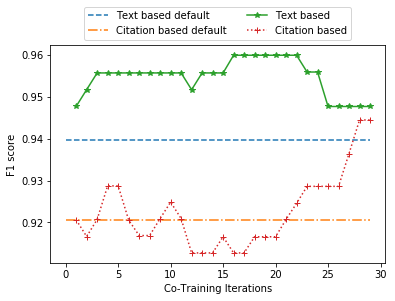

              precision    recall  f1-score   support

p_robinson_0       0.94      0.98      0.96       119
p_robinson_1       0.98      0.95      0.97       133

   micro avg       0.96      0.96      0.96       252
   macro avg       0.96      0.97      0.96       252
weighted avg       0.97      0.96      0.96       252

[117   2   7 126]
[{'author': 'p_robinson', 'fold': 1, 'train_size': [('p_robinson_0', 5), ('p_robinson_1', 5)], 'test_size': 26, 'total_self_labeled_train': 120, 'unlabeled size': 216, 'co-train f1': 1.0}, {'author': 'p_robinson', 'fold': 2, 'train_size': [('p_robinson_0', 5), ('p_robinson_1', 5)], 'test_size': 26, 'total_self_labeled_train': 115, 'unlabeled size': 216, 'co-train f1': 1.0}, {'author': 'p_robinson', 'fold': 3, 'train_size': [('p_robinson_0', 5), ('p_robinson_1', 5)], 'test_size': 26, 'total_self_labeled_train': 116, 'unlabeled size': 216, 'co-train f1': 0.9614814814814816}, {'author': 'p_robinson', 'fold': 4, 'train_size': [('p_robinson_0', 5), ('p

In [4]:
import collections
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# fix random seed for reproducibility
np.random.seed(1)

# loop through all files in directory add name to name list
fileDir = "../Data/"+Dataset+"/canopies_labeled/"
listfiles = os.listdir(fileDir)

init_labeled_size = 10

co_lr_diff_embedding_result = []

#---------------- load different embeddings for view one ---------------#
for select_emb in pp_text:
    print("Load text embedding: ", select_emb)
    # read viewone embeddings
    viewone_text_emb, viewone_emb_pid = com_func.read_text_embedding(emb_type=select_emb, training_size = "140k")
    viewone_text_emb = np.column_stack((viewone_emb_pid,viewone_text_emb))
    # read viewtwo embedding, notice here we only use labeled data
    print("Load citation embedding: ", pp_citation)
    viewtwo_citation_embedding = com_func.read_citation_embedding_sorted(emb_type = pp_citation, labeled_only = True)
    # print(viewone_text_emb[0])
    # print(viewtwo_citation_embedding[0])
    
    threshold_change_all_co_lr_f1s = []
    threshold_change = []
    
    # -------------- different threshold (step by 10) -----------------------#
    for step_threshold in range(threshold_lower, threshold_upper, 10):
        plot_save_path = "../../plot/co_train_ppt_plots/threshold="+str(step_threshold)+"/binary_sample=140k/"+select_emb+"/"
        threshold_change.append(step_threshold)
        # collect statistic to output
        name_group, total_sample_size, train_sample_size, test_sample_size= ([] for i in range(4))
        unlabeled_count, co_train_self_labeled = ([] for i in range(2))

        all_LR_f1,all_SVM_f1, all_co_LR_f1 = ([] for i in range(3))
        all_per_fold_f1_score_variance = []

        total_selected_group = 0

        # ------- different name group in all name group --------------------#
        for file in listfiles:
            # group name
            temp = file.split("_")
            name = temp[1]+"_"+temp[-1]
            print("For name: ",name)
            # read labeled pid and aid from file
            data = com_func.read_pid_aid(fileDir+file)
            labeled_mask = data["authorID"] != "-1"
            labeled_data = data[labeled_mask]
            print(labeled_data.shape)
            # ---------------- collect all labeled sample -------------------- #
            # ---------------- if use all samples as negative --------------- #
            all_labeled_samples = labeled_data["paperID"].tolist()
            authorCounter = com_func.select_productive_groups(labeled_data, threshold_select_name_group)
            # if only have one class or no class pass the threshold, not applicable
            if(len(authorCounter)==0) or (len(authorCounter)==1):
                print(name," pass")
            else:
                total_selected_group+= 1
                # --------------for each name group---------------- #
                if apply_threshold_to_name_group_samples == True:
                    # ---------- only use sample pass threshold ------- #
                    #-------- only select authors in name group are very productive (more than threshold)---------#
                    labeled_data, author_list, _= com_func.only_select_productive_authors(labeled_data, step_threshold)
                    # ----------------- if use filtered samples as negative  --------- #
                    filtered_all_labeled_samples = labeled_data["paperID"].tolist()
                else:
                    # ----------- use all sample in name group --------- #
                    author_list = com_func.productive_authors_list(labeled_data, step_threshold)
                    print(name, " name group sample size: ",labeled_data.shape)
                # -------------- extract all samples for name group -------------- #
                # for each name group
                # read in labeled data
                labeled_viewone_text = com_func.extract_sorted_embedding(viewone_text_emb, labeled_data["paperID"])
                print(labeled_viewone_text.shape)
                labeled_viewtwo_citation = com_func.extract_sorted_embedding(viewtwo_citation_embedding, labeled_data["paperID"])
                print(labeled_viewtwo_citation.shape)
                print("Labeled: ",len(labeled_viewone_text), " : ", len(labeled_viewtwo_citation))
                # ---------------- shuffle the data ----------------- #
                labeled_data = labeled_data.sample(frac=1).reset_index(drop=True)
                # ------------------ alignment ---------------------- #
                labeled_viewone_text = pd.merge(labeled_data, labeled_viewone_text, left_on="paperID", right_on = [0], how = "left")
                labeled_viewtwo_citation = pd.merge(labeled_data, labeled_viewtwo_citation, left_on="paperID", right_on = [0], how = "left")
                labeled_viewtwo_citation.fillna(0, inplace=True)
                unique_labels = labeled_viewone_text.authorID.unique()
                map_dict = {}
                for idx, unique_label in enumerate(unique_labels):
                    map_dict[unique_label] = name+"_"+str(idx)
                true_label = labeled_viewone_text["authorID"].replace(map_dict)
                
                print(labeled_viewone_text.shape)
                print(labeled_viewtwo_citation.shape)
                '''
                only work on binary case, ignored multi-class case
                We need to check whether the name group only contain binary case or not
                '''
                if len(author_list) == 2:
                    name_group.append(name)
                    print(name + " is binary case")
                    viewone_text_final = labeled_viewone_text.drop(["paperID", "authorID", 0], axis=1)
                    viewtwo_citation_final = labeled_viewtwo_citation.drop(["paperID", "authorID", 0], axis=1)
                    '''Only for visualization of co-training process, use PCA to reduce views to 2d'''
                    # 1. apply PCA to different views
                    pca = PCA(n_components=2)
                    pca_dv1 = pca.fit_transform(X=viewone_text_final)
                    pca_dv2 = pca.fit_transform(X=viewtwo_citation_final)
                    
                    # 2. apply co-training
                    co_logistic_clf = Co_training_clf(clf1=LogisticRegression(solver= "liblinear"),p=1,n=1, k=30)
                    co_lr_f1, author_per_fold_status= k_fold_cv_co_train_binary(pca_dv1, pca_dv2, true_label, 
                                                                                init_labeled_size, co_logistic_clf, 
                                                                                10, name, plot_save_path)
                    print(author_per_fold_status)
                    total_sample_size.append(len(true_label))
                    train_sample_size.append(author_per_fold_status[0]["train_size"])
                    test_sample_size.append(author_per_fold_status[0]["test_size"])
                    unlabeled_count.append(author_per_fold_status[0]["unlabeled size"])
                    co_train_self_labeled.append(author_per_fold_status[0]["total_self_labeled_train"])
                    all_co_LR_f1.append(co_lr_f1)
                    break
                else:
                    print(name+ " is multi-class case, ignored")
                    
        # write evaluation result to excel
        output = pd.DataFrame({'Name':name_group, "Total sample size":total_sample_size, "train size":train_sample_size,
                               "test size":test_sample_size, "unlabeled sample size": unlabeled_count, 
                               "total self labeled sample":co_train_self_labeled, "co_logisticRegression F1": all_co_LR_f1})
        print("Done")
        
        threshold_change_all_co_lr_f1s.append(all_co_LR_f1)
        
    co_lr_diff_embedding_result.append(threshold_change_all_co_lr_f1s)

In [ ]:
from statistics import mean 

print(threshold_change_all_co_lr_f1s)
print(co_lr_diff_embedding_result)

In [ ]:
#         # --------------- plot overall result f1 variance --------------- #
#         all_per_fold_f1_score_variance_plot = pd.DataFrame(all_per_fold_f1_score_variance)
#         ax = sns.boxplot(x="author", y="f1", data=all_per_fold_f1_score_variance_plot)
#         ax = sns.swarmplot(x="author", y="f1", data=all_per_fold_f1_score_variance_plot, color=".25")
#         plt.savefig(plot_save_path+"all_result_variance.png", dpi=300)
#         # plt.show()

In [ ]:
# %whos
del viewtwo_citation_embedding
del viewone_text_emb